In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, BatchNormalization, Flatten, Dense
import numpy as np
from keras_facenet import FaceNet
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
IMG_SHAPE = (196, 196)

In [4]:
embedder = FaceNet()

In [5]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    basic_loss = tf.maximum(pos_dist - neg_dist + alpha, 0)
    return tf.reduce_sum(basic_loss)

In [7]:
img1 = np.array(Image.fromarray(plt.imread("./test_images/dean.jpg")).resize(IMG_SHAPE))[:, :, :3]
img2 = np.array(Image.fromarray(plt.imread("./test_images/dean2.jpg")).resize(IMG_SHAPE))[:, :, :3]

In [8]:
embeddings_1 = embedder.embeddings(img1.reshape(1, 196, 196, 3))
embeddings_2 = embedder.embeddings(img2.reshape(1, 196, 196, 3))

1/1 [==============================] - 0s 24ms/step


In [9]:
embeddings_1[0, :5]

array([ 0.04321618, -0.05667878,  0.03233059, -0.02216236, -0.01784528],
      dtype=float32)

In [10]:
embeddings_2[0, :5]

array([ 0.02544262, -0.04454208,  0.06017091,  0.03770782,  0.03235031],
      dtype=float32)

In [11]:
#tf.keras.backend.set_image_data_format('channels_last')
def img_to_encoding(image_path, model):
    img = np.array(Image.fromarray(plt.imread(image_path)).resize(IMG_SHAPE))[:, :, :3]
    print(img.shape)
    embedding = model.embeddings(img.reshape(1, 196, 196, 3))
    return embedding / np.linalg.norm(embedding, ord=2)

In [12]:
database = {}
database["dean"] = img_to_encoding("test_images/dean.jpg", embedder)
database["sam"] = img_to_encoding("test_images/sam.jpg", embedder)
database["castiel"] = img_to_encoding("test_images/castiel.jpg", embedder)

(196, 196, 3)
1/1 [==============================] - 0s 24ms/step
(196, 196, 3)
1/1 [==============================] - 0s 21ms/step
(196, 196, 3)
1/1 [==============================] - 0s 23ms/step


In [13]:
database["dean"][0, :5]

array([ 0.04321618, -0.05667878,  0.03233059, -0.02216236, -0.01784528],
      dtype=float32)

In [14]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
        image_path -- path to an image
        identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
        database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
        model -- your Inception model instance in Keras
    
    Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
    """
    door_open = False
    encoding = img_to_encoding(image_path, model)
    actual_encoding = database[identity]
    distance = tf.reduce_sum(tf.square(encoding-actual_encoding), axis=1)
    if distance <= 0.7 :
        door_open = True
    return distance, door_open

In [15]:
distance, door_open_flag = verify("test_images/dean2.jpg", "dean", database, embedder)
print(distance)
print(f"Door is {'open' if door_open_flag else 'closed!'}!")

(196, 196, 3)
1/1 [==============================] - 0s 25ms/step
tf.Tensor([0.53275263], shape=(1,), dtype=float32)
Door is open!


In [16]:
distance, door_open_flag = verify("test_images/sam.jpg", "dean", database, embedder)
print(distance)
print(f"Door is {'open' if door_open_flag else 'closed!'}!")

(196, 196, 3)
1/1 [==============================] - 0s 35ms/step
tf.Tensor([1.818489], shape=(1,), dtype=float32)
Door is closed!!


In [17]:
distance, door_open_flag = verify("test_images/castiel.jpg", "dean", database, embedder)
print(distance)
print(f"Door is {'open' if door_open_flag else 'closed!'}!")

(196, 196, 3)
1/1 [==============================] - 0s 24ms/step
tf.Tensor([1.5311261], shape=(1,), dtype=float32)
Door is closed!!


(196, 196, 3)
1/1 [==============================] - 0s 23ms/step
(196, 196, 3)
1/1 [==============================] - 0s 23ms/step


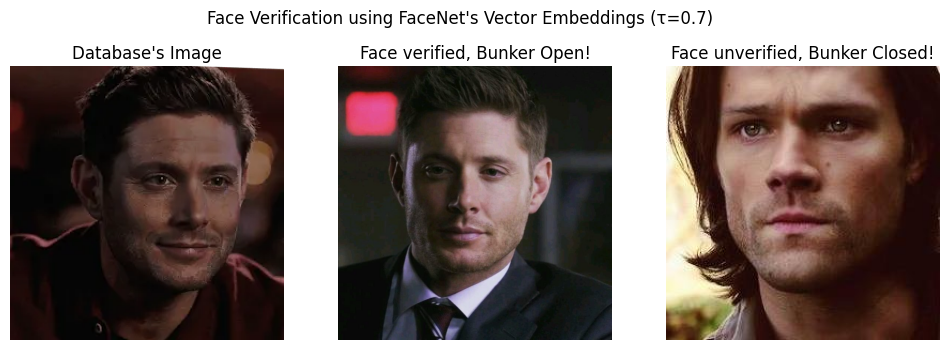

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Face Verification using FaceNet's Vector Embeddings (τ=0.7)")
axes[0].imshow(plt.imread("./test_images/dean.jpg"))
axes[0].set_title("Database's Image")

distance, door_open_flag = verify("test_images/dean2.jpg", "dean", database, embedder)
axes[1].imshow(plt.imread("./test_images/dean2.jpg"))
axes[1].set_title('Face verified, Bunker Open!' if door_open_flag else 'Face unverified, Bunker Closed!')

distance, door_open_flag = verify("test_images/sam.jpg", "dean", database, embedder)
axes[2].imshow(plt.imread("./test_images/sam.jpg"))
axes[2].set_title('Face verified, Bunker Open!' if door_open_flag else 'Face unverified, Bunker Closed!')
for ax in axes.flat:
    ax.axis('off')
fig.savefig("./results.jpg", dpi=200)